## GPR FIT with Supernova distances and redshifts (part 2 - 3)

### Part 2 (start in class)

First let's fit our supernova synthetic data from last time using GPR.

- The key ingredient in getting a good GPR fit is the choice of the kernel and its parameters.
- Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- But check out what's available in the `kernels` submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

*Note*. To start with, feel free to tweak the hyperparameters manually. But, of course, a publication-quality result will require a cross-validation analysis.

TO DOOO!!!!
The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much much better.
- Think about the pdf of these data in $z$.
- Using your GPR fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from astroML.datasets import generate_mu_z
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern
from sklearn.model_selection import KFold

%config InlineBackend.figure_format='retina'
plt.rcParams['figure.figsize'] = [8, 8]


<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
C:\Users\simon\AppData\Local\Temp\ipykernel_3260\224906477.py:5: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu$")


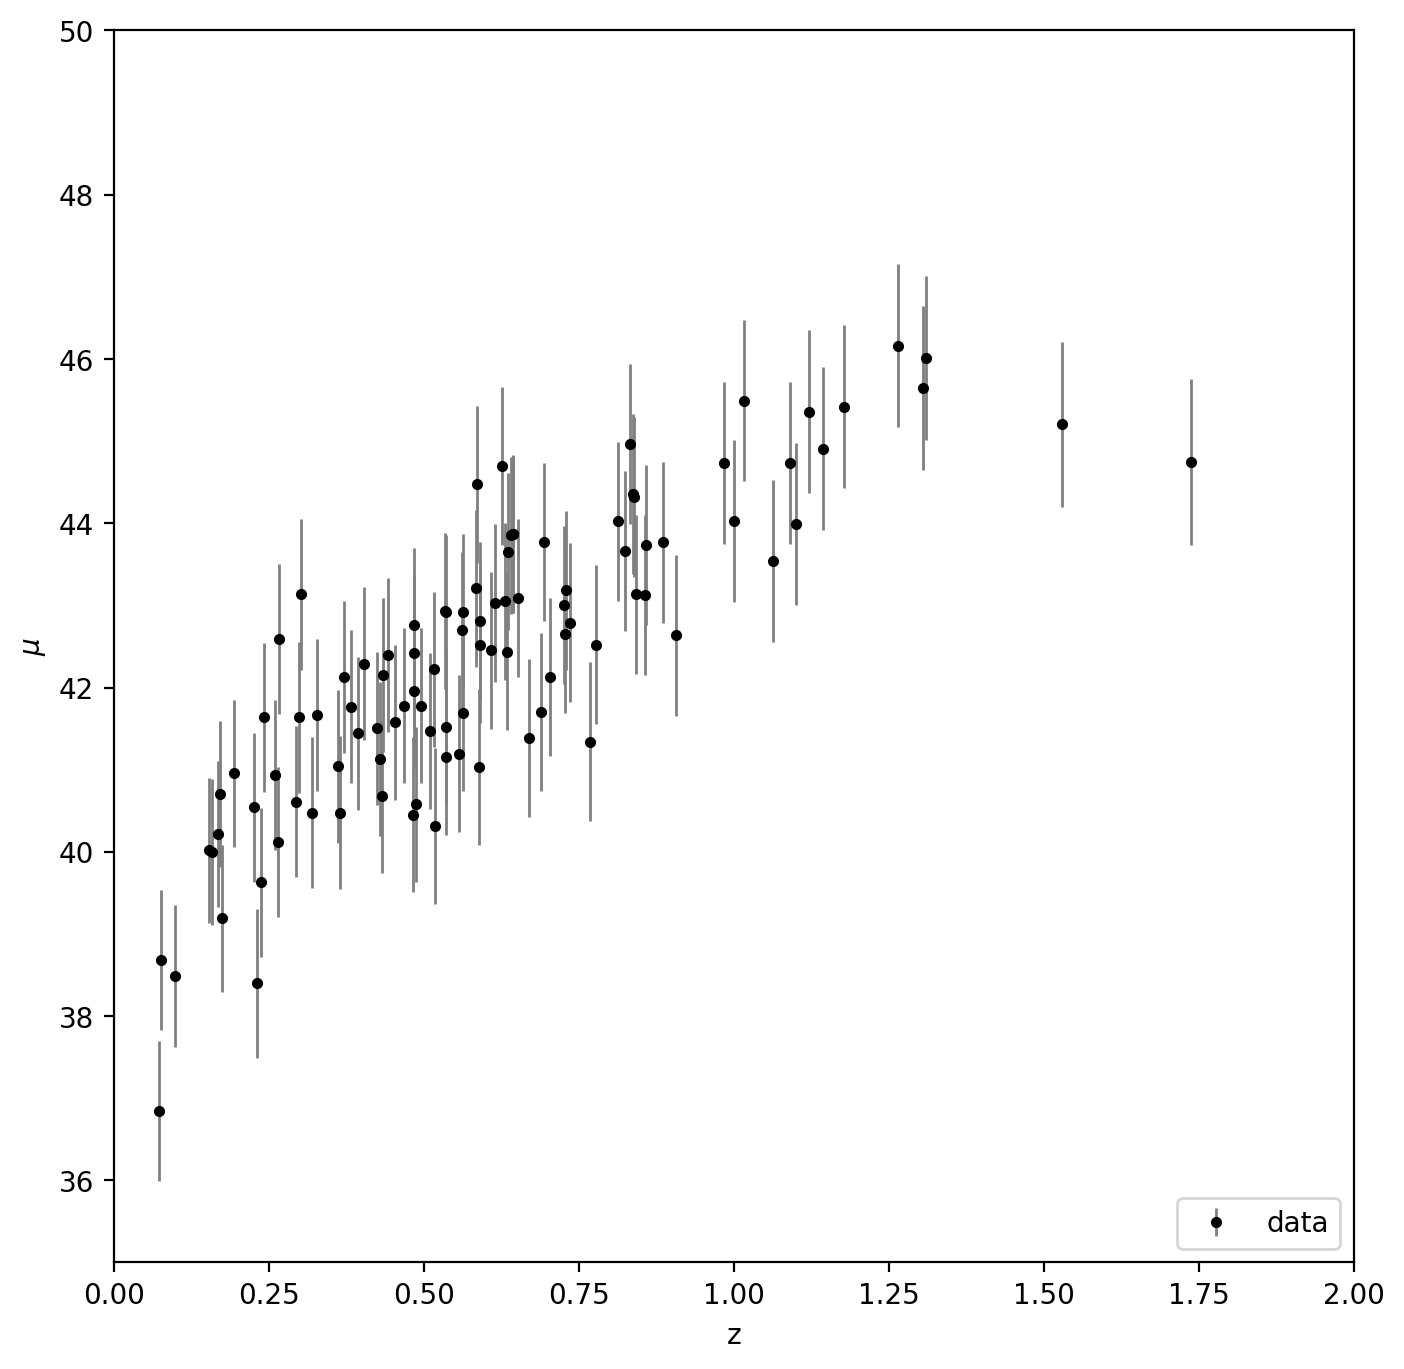

In [2]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234) ###YOU CAN'T CHANGE THIS

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

### GPR fit with RBF and MATERN kernel

##### About the Kernel I used (under)
I use a **Scaled RBF Kernel**:
$$
 \text{Scaled RBF Kernel} = \text{Constant Kernel} * \text{RBF Kernel}
$$
 where
- Constant Kernel controls the vertical scale (variance)
- RBF controls the horizontal scale (how fast the function varies).

**RBF kernel**: 

$$
k(x, x') = \exp\left( -\frac{(x - x')^2}{2 \cdot \text{length\_scale}^2} \right)
$$

The *length scale* determines how far you have to move in input space for the function value to change significantly.

- If length_scale is small, even small changes in x produce big changes in the kernel value → the function is wiggly (high-frequency).
- If length_scale is large, the kernel changes slowly → the function is smoother and varies gradually.

**Constant Kernel**

$$
k_{const}(x, x') = \text{constant value}
$$



(I also try to use **Matern Kernel**)

In [3]:
# Grid of values to plot the line
z_line = np.linspace(z_sample.min()-1, z_sample.max()+1, 100).reshape(-1, 1)

<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
C:\Users\simon\AppData\Local\Temp\ipykernel_3260\1506267134.py:18: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu$")


(35.0, 50.0)

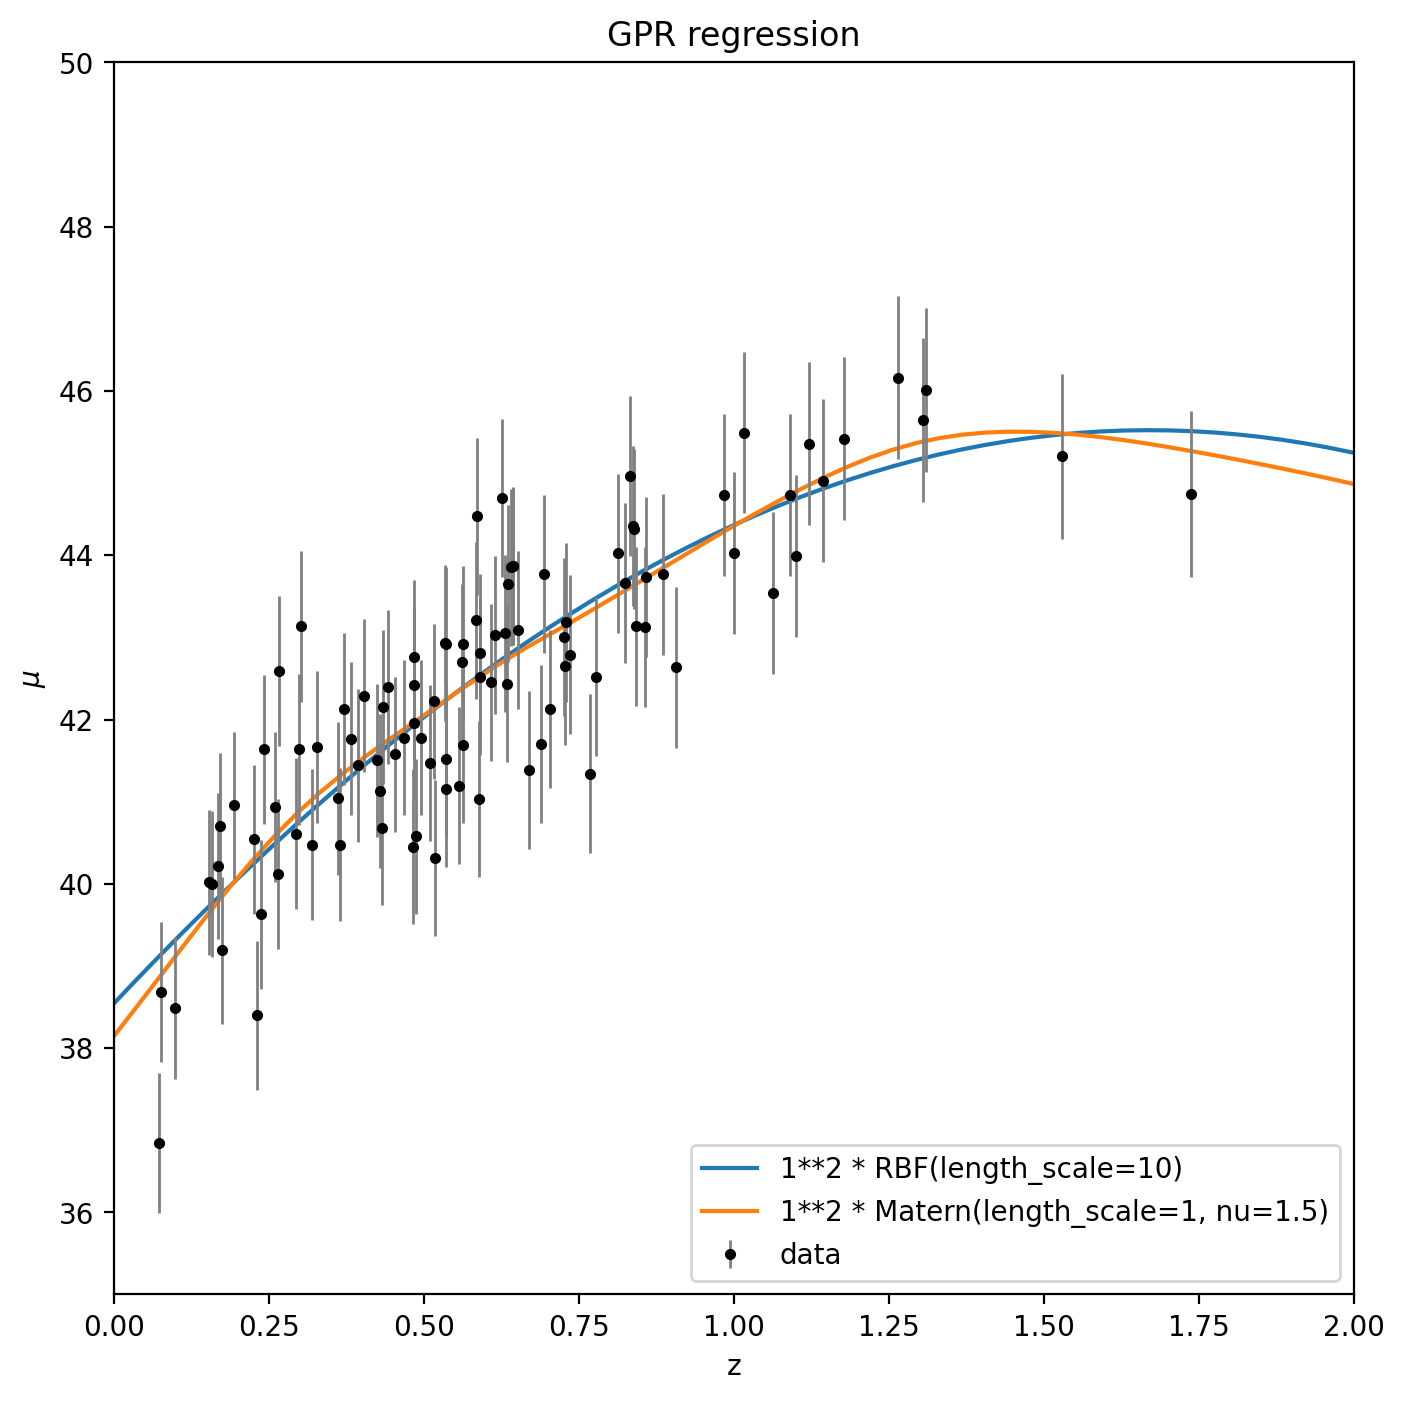

In [4]:
# Choose the kernel
kernels = [
    ConstantKernel(1.0) * RBF(length_scale=10),
    ConstantKernel(1.0) * Matern(length_scale=1.0, nu=1.5),
]


for kernel in kernels:
    gp = GaussianProcessRegressor(kernel=kernel, alpha=dmu**2 ) # Alpha is the variance of additional Gaussian measurement noise on the training observations
    gp.fit(z_sample[:, None], mu_sample)
    mu_pred, dmu_pred = gp.predict(z_line, return_std=True)

    plt.plot(z_line, mu_pred, label=f'{kernel}')

# Plot
plt.errorbar(z_sample, mu_sample, yerr=dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title("GPR regression")
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)

### K-Fold Cross Validation & plot 1-$\sigma$ and 2-$\sigma$ contours

K-fold cross validation to choose lenght-scale of RBF and Constant kernel

In [5]:
# Define a search grid
constants = np.geomspace(0.1, 100, 20) # 20 log-spaced values from 0.1 to 100
length_scales = np.linspace(1, 100, 40) #  40 linearly spaced values from 1 to 100

kf = KFold(n_splits=5, shuffle=True, random_state=8) # 5-fold cross-validation: the data is split into 5 parts, and each fold is used once as validation

crossval_error = [] # I will fill with (constants, scales, crossvalidation error)
for c in constants: 
    for ls in length_scales:
        error_validation = []
        for train_idx, val_idx in kf.split(z_sample): # Generate indices to split data into training and test set, changing validation fold every loop (uses 1 for validation, 4 for training)
                                                      # 5 loops  
            # Split in data train and validation
            z_train, z_validation = z_sample[train_idx], z_sample[val_idx]
            mu_train, mu_validation = mu_sample[train_idx], mu_sample[val_idx]
            dmu_train, dmu_val = dmu[train_idx], dmu[val_idx]

            # fit and extract error
            kernel = ConstantKernel(c) * RBF(length_scale=ls)
            gp = GaussianProcessRegressor(kernel=kernel, alpha=dmu_train**2 )
            gp.fit(z_train.reshape(-1, 1), mu_train) # I fit using only the training set data
            error = np.sqrt( np.sum(( mu_validation - gp.predict(z_validation.reshape(-1, 1)) )**2) / len(z_validation) )
            error_validation.append(error)
        
        # print(error_validation)
    
        crossval_error.append((c, ls, np.mean(error_validation))) # Mean over the five validation error produced for every c and ls

best_kernel_params = min(crossval_error, key=lambda x: x[2]) # Compare using the 3rd item in each tuple (x[2] = the average error)
for cv in crossval_error:
    print(f"Constant = {cv[0]:.3f} \t Length Scale = {cv[1]:.3f} \t Cross Validation Error = {cv[2]:.4f}")

print(f"\n Best kernel parameters: Constant {best_kernel_params[0]}, Length Scale {best_kernel_params[1]}")
            

Constant = 0.100 	 Length Scale = 1.000 	 Cross Validation Error = 0.9334
Constant = 0.100 	 Length Scale = 3.538 	 Cross Validation Error = 1.4443
Constant = 0.100 	 Length Scale = 6.077 	 Cross Validation Error = 1.3869
Constant = 0.100 	 Length Scale = 8.615 	 Cross Validation Error = 0.9338
Constant = 0.100 	 Length Scale = 11.154 	 Cross Validation Error = 0.9334
Constant = 0.100 	 Length Scale = 13.692 	 Cross Validation Error = 1.3035
Constant = 0.100 	 Length Scale = 16.231 	 Cross Validation Error = 0.9334
Constant = 0.100 	 Length Scale = 18.769 	 Cross Validation Error = 0.9334
Constant = 0.100 	 Length Scale = 21.308 	 Cross Validation Error = 0.9334
Constant = 0.100 	 Length Scale = 23.846 	 Cross Validation Error = 0.9334
Constant = 0.100 	 Length Scale = 26.385 	 Cross Validation Error = 0.9334
Constant = 0.100 	 Length Scale = 28.923 	 Cross Validation Error = 0.9334
Constant = 0.100 	 Length Scale = 31.462 	 Cross Validation Error = 0.9334
Constant = 0.100 	 Length Sca

Plot with confidence belt

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\m'
C:\Users\simon\AppData\Local\Temp\ipykernel_3260\3981911562.py:9: SyntaxWarning: invalid escape sequence '\s'
  plt.fill_between(z_line.reshape(-1), mu_pred - dmu_pred, mu_pred + dmu_pred, alpha=0.2, label='1$\sigma$ interval', color = 'CornflowerBlue')
C:\Users\simon\AppData\Local\Temp\ipykernel_3260\3981911562.py:10: SyntaxWarning: invalid escape sequence '\s'
  plt.fill_between(z_line.reshape(-1), mu_pred - 2 * dmu_pred, mu_pred + 2 * dmu_pred, alpha=0.3, label='2$\sigma$ interval', color = 'CornflowerBlue')
C:\Users\simon\AppData\Local\Temp\ipykernel_3260\3981911562.py:15: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu$")


(35.0, 50.0)

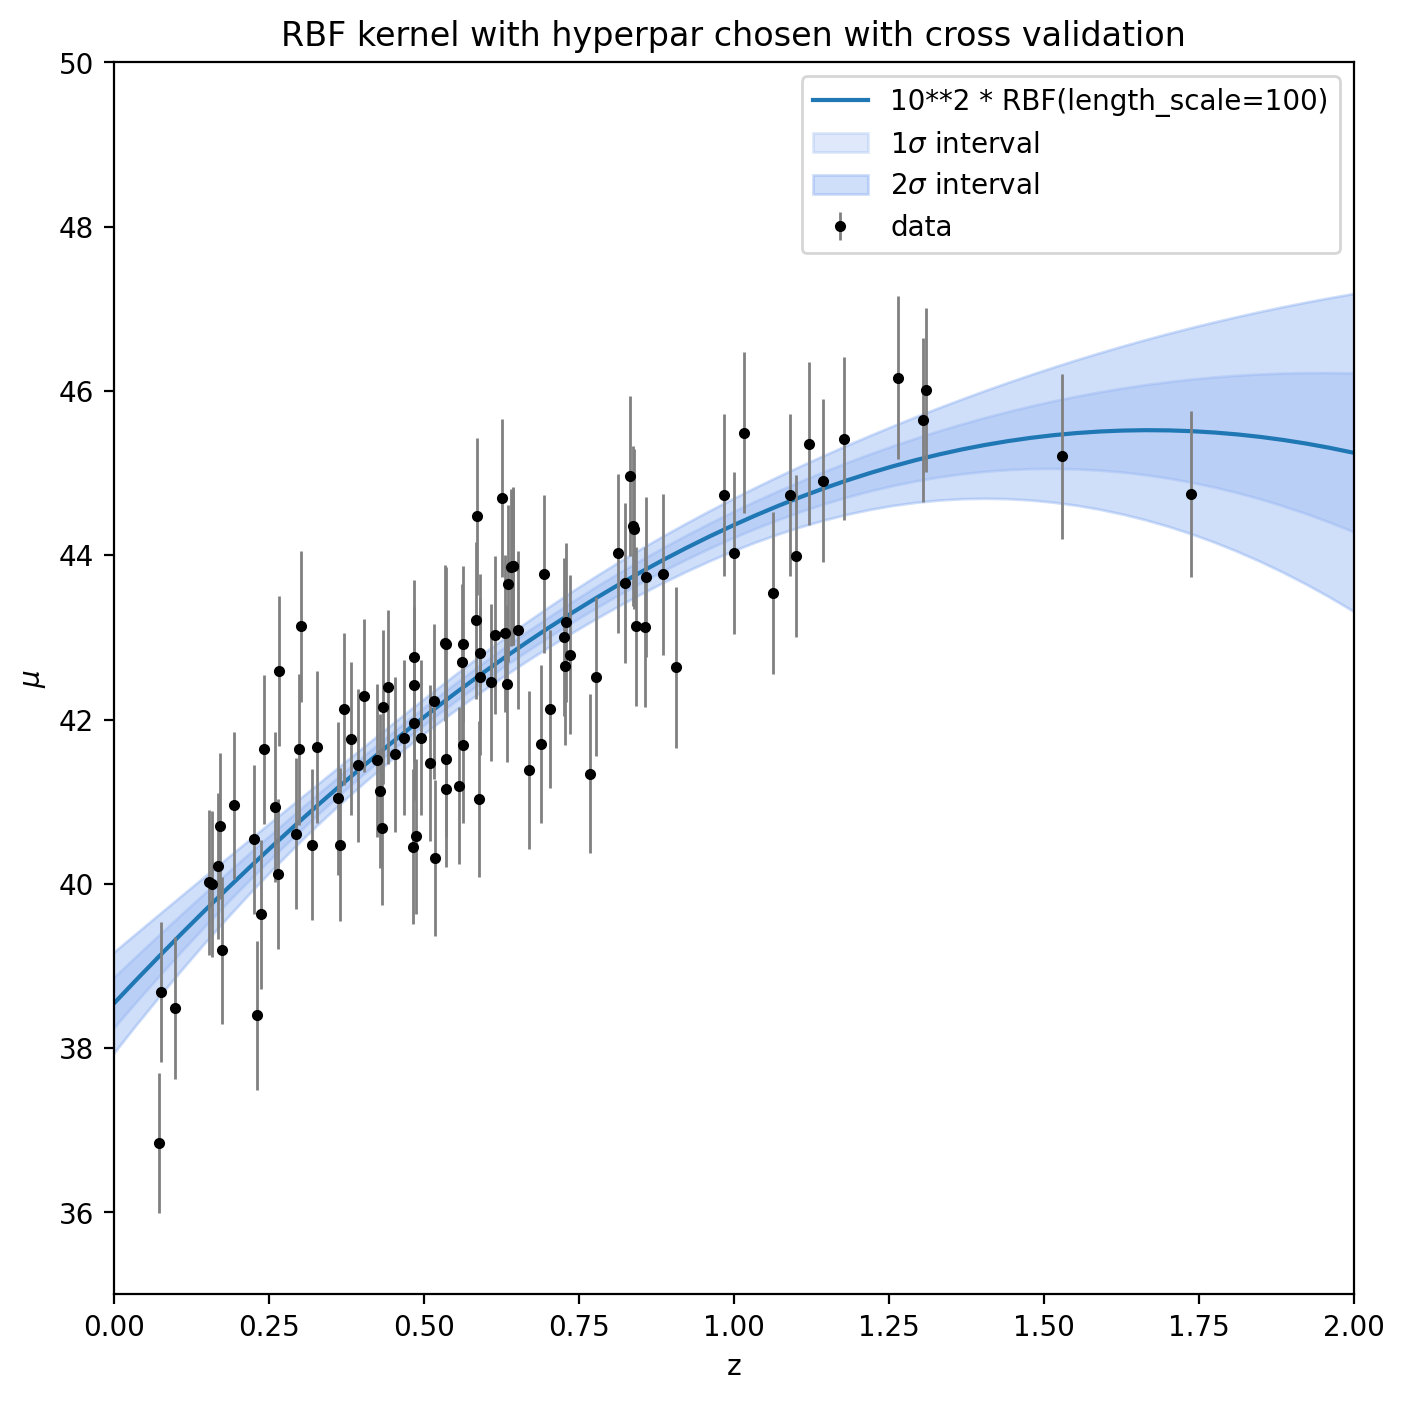

In [6]:
kernels = ConstantKernel(best_kernel_params[0]) * RBF(length_scale=best_kernel_params[1])

gp = GaussianProcessRegressor(kernel=kernel, alpha=dmu**2 ) # Alpha is the variance of additional Gaussian measurement noise on the training observations
gp.fit(z_sample[:, None], mu_sample)
mu_pred, dmu_pred = gp.predict(z_line, return_std=True)

# Plot
plt.plot(z_line, mu_pred, label=f'{kernel}')
plt.fill_between(z_line.reshape(-1), mu_pred - dmu_pred, mu_pred + dmu_pred, alpha=0.2, label='1$\sigma$ interval', color = 'CornflowerBlue')
plt.fill_between(z_line.reshape(-1), mu_pred - 2 * dmu_pred, mu_pred + 2 * dmu_pred, alpha=0.3, label='2$\sigma$ interval', color = 'CornflowerBlue')


plt.errorbar(z_sample, mu_sample, yerr=dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title("RBF kernel with hyperpar chosen with cross validation")
plt.legend()
plt.xlim(0, 2)
plt.ylim(35, 50)

For large redshift values, my prediction has bigger uncertainty. In general it fit well.

### Part 3 (for the exam)

*(I know this assignment is longer and more convoluted, but we're getting towards the end of the class and it's important to draw connections between the different things we've done)*

We now have a suite of **data-driven** predictive models for our supernova dataset (from polynomials to GPR). That is: we can faithfully predict how a future redshift/distance measurement will look like given the current sample.

This is already great and these kind of tools are immensely useful in a variety of contexts (also involving a lot of money: suppose you want to predict how much a give financial asset will perform on tomorrow's stock market... You  might not really care about expressing the underlying financial model in simple terms, as long as your investments are profitable).

For the case of supernovae, however, we have do have physical theory which is $\Lambda$CDM. We can do a **parametric** fit (and hopehully by now the difference between "parametric" and "data driven" fit is clear in your head)

- First, refresh your cosmology and write down the predicted relationship between the distance module $\mu$ and the redshift $\sigma$. *Hint* I always forget these things, my to-go reference is [Hogg (2010)](https://arxiv.org/abs/astro-ph/9905116). The answer is:

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$


- Assuming a flat Universe,  we have a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$
- It's a very non-linear model. Fit it to the data (however you want to do it, are you frequentist or Bayesian after all?).
- What are the measured value of $H_0$ and $\Omega_m$. Are they correlated?
- How would a model without dark energy (i.e. $\Omega_m=1$) perform? Do these data contain evidence of dark energy? (Hint: this is a model selection problem!)





[My exploration](https://github.com/dgerosa/astrostatistics_bicocca_2025/blob/main/solutions/S18_supernovae2.ipynb)